In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import date
import time
from pandas_datareader import data
import yfinance as yf  # yfinance manuels: https://github.com/ranaroussi/yfinance

In [44]:
today=date.today()
# At the begining checkList is empty
checkList=[]

In [45]:
# publisc functions
def getTicker():
    # Let user enter target market, return price dataframe
    wel_txt='Please let me know what stock information you want to know.'
    symbol=input(wel_txt).upper()
    symbolSignal=enterSymbol(symbol)
    print('I am checking', symbol)
    # print(symbolSignal.SymbolCheck())
    if symbolSignal.SymbolCheck() == 1:
        symbolDf=data.get_data_yahoo(symbol,'2017-01-01', today)
        # In eachtime user successed load a symbol, it will be add into list
        checkList.append(symbol)
        print(symbolDf.tail(1))
        return symbolDf
    else:
        print('The symbol you entered is not list in Bot. Sorry.')
        
def cleanList(checklist):
    return list(set(checklist))
    
    
# Use all symbols to create a multi-graph
def createGraph(checklist):
    stock1=cleanList(checklist)[0]
    stock1Df=data.get_data_yahoo(stock1,'2017-01-01', today)
    ax1=stock1Df.plot(y="Close", use_index=True, label=stock1)
    for symbol in cleanList(checklist)[1::]:
        data.get_data_yahoo(symbol,'2017-01-01', 
                            today).plot(ax=ax1,y="Close", 
                                        use_index=True, label=symbol)
    plt.xlabel('Datetime')
    plt.ylabel('Price(USD)')
    plt.title("Comparation of Symbols")
    plt.grid(True)
    plt.show()
    
def mergeData(checklist):
    # merge close price data
    closeDf=pd.DataFrame()
    for symbol in cleanList(checklist):
        symbolDf=data.get_data_yahoo(symbol,'2017-01-01', today)
        closeDf=pd.concat([closeDf,symbolDf["Close"]], axis=1)
    # Rename header
    closeDf.columns=cleanList(checklist)
    # Check data
    print(closeDf.tail())
    return closeDf

def correlation(checklist):
    return mergeData(cleanList(checklist)).corr()

# Compute Cummulative portfolio return and plot it.
def cumulative_returns_plot(label_list):
    for name in label_list:
        CumulativeReturns = ((1 + stockReturn[name]).cumprod()-1)
        CumulativeReturns.plot(label=name)
    plt.legend()
    plt.show()
    


In [46]:
class enterSymbol():
    '''
    enterSymbol is a easy checker to
    make sure the symbol that user's entered
    is valid to get ticker from Yahoo.
    If symbolValid is 1, then will return positive infor.
    '''
    def __init__(self, symbol):
        self.symbol=str(symbol)
    
    
    def SymbolCheck(self):
        start_txt='I am checking'+self.symbol
        symbolValid=0
        if len(self.symbol) != 0:
            symbolValid=1
            if self.SymbolChecker() == True:
                return symbolValid
            else:
                symbolValid=0
                print('Symbol not found')
        else:
            symbolValid=0
            print('I cannot found information.')
            
    def SymbolChecker(self):
        try:
            data.get_data_yahoo(self.symbol,'2020-12-31',today).info
        except:
            return False
        else:
            return True

In [47]:
class priceData():
    '''Once we get the data from yahoo, we can have
    different method to analyze the stock
    '''
    def __init__(self, symbol):
        self.symbol=symbol
        self.dataframe=data.get_data_yahoo(symbol,'2017-01-01',today)
        
    def getStatisticalInfo(self):
        # To get statistic data for everyday close price
        print(self.dataframe['Close'].describe())
    
    def change(self):
        closeCol=self.dataframe['Close']
        # Buy Price
        buyPrice=closeCol[0]
        # Present Price
        curPrice=closeCol[closeCol.size-1]
        # cummulate gross
        priceChange=(curPrice-buyPrice)/buyPrice
        if (priceChange>0):
            print('Stock grossed:', priceChange*100,'%')
        elif (priceChange==0):
            print('Stock no PNL')
        else:
            print('Stock lost:', priceChange*100,'%')
        return priceChange
    
    def priceTrend(self):
        # Price Trend
        '''X-axis is date index, y is the close price
        in default, plot will return line graph'''
        # plot use_index=True will automatic use Datetime index as X-axis
        self.dataframe.plot(y="Close",use_index=True,color='b',label='price')
        plt.xlabel('Date')
        plt.ylabel('Price(USD)')
        plt.title(self.symbol+' Price')
        plt.grid(True)  # Turn on grid
        plt.legend(loc='best') # Turn on legend
        plt.show()
        
    def priceVPVR(self):
        # Volume Profile Visible Range
        '''X-axis is volume of traded
        y-axis is Close price
        the graph use bar'''
        self.dataframe.plot(x='Volume',y='Close',kind='scatter')
        plt.xlabel('Volume')
        plt.ylabel('Price(USD)')
        plt.title("VPVR")
        plt.grid(True)
        plt.show()
    
    def correlation(self):
        return self.dataframe.corr()

In [48]:
class portfolioManage():
    def __init__(self, checklist):
        self.checklist=cleanList(checklist)

    def dailyChange(self):
        portDf=mergeData(self.checklist)
        portDf=portDf.dropna()
        port_pct_change = portDf.pct_change()
        port_pct_change.fillna(0, inplace=True)
        #self.portDf=portDf
        self.port_pct_change=port_pct_change
        return port_pct_change

    def expectedReturn(self):
        expreturn = np.array(self.port_pct_change.mean())
        self.expreturn=expreturn
        return expreturn

    def varianceCovariance(self):
        # var_covar matix = 
        # transpose(stock price value changes - expect return) * (stock price value changes - expect return)
        var_covar = np.dot((self.port_pct_change.values-self.expreturn).T,
                           (self.port_pct_change.values-self.expreturn))
        return var_covar
    
    def marketCap(self):
        # Using marketCap to assume the weight of portfolio
        marketcapita=pd.DataFrame(columns=['marketCap'])
        for sym in self.checklist:
            capita=yf.Ticker(sym).info['marketCap']
            marketcapita.loc[sym,'marketCap']=capita
        self.marketcapita=marketcapita
        return marketcapita
    
    # Before run this function, we need run portfolioManage.marketCap() first.
    def portfolioWeight(self):
        global marketWeight
        marketWeight=pd.DataFrame(columns=['weight'])
        for sym in self.checklist:
            marketWeight.loc[sym,'weight']=self.marketcapita.loc[sym,'marketCap']/self.marketcapita['marketCap'].sum()
        return marketWeight

In [49]:
class portfolioMinGraph():
    def __init__(self, checklist):
        self.checklist=cleanList(checklist)
        
    # This function is the main data resourse, need run first.
    def plotWeightedReturn(self):
        # we need to get marketCap first, then we can obtain CapWeight
        targetStock=portfolioManage(self.checklist)
        targetStock.marketCap()
        portWeights=targetStock.portfolioWeight() # Before normalization, we get
        # marketCap weight first.
        global stockReturn
        stockReturn = targetStock.dailyChange()
        stock_ret = stockReturn.copy()
        weightedReturn = stock_ret.mul(np.array(portWeights.T), axis=1)
        # using marketCap weight, to assuming an expected return.
        stockReturn['Portfolio'] = weightedReturn.sum(axis=1)
        # Use marketCap Weight, the return of the portfolio in each day.
        stockReturn.Portfolio.plot()
        plt.show()
        self.stockReturn = stockReturn
        self.stock_ret = stock_ret
        self.portWeights = portWeights
    
   

    # Create Matix
    def corHeatmap(self):
        sns.heatmap(correlation(self.checklist),
                annot=True,
                cmap="YlGnBu", 
                linewidths=0.3,
                annot_kws={"size": 8})
        plt.xticks(rotation=90)
        plt.yticks(rotation=0) 
        plt.show()
    
    # Run first if need var-cor matrix
    def covAnuMatrix(self):
        covMatrix = self.stock_ret.cov()
        covMatrixAnnual = covMatrix * 252
        self.covMatrix = covMatrix
        self.covMatrixAnnual = covMatrixAnnual
        print(covMatrixAnnual)
    
    # In portfolio volatility, we need to use 3X1 array as weight to caltulate.
    def volatility(self):
        portfolioVar = np.dot(self.portWeights.T,np.dot(self.covMatrixAnnual, self.portWeights))
        portfolioVolatility = np.sqrt(float(portfolioVar))
        self.portfolioVolatility = portfolioVolatility
        return portfolioVolatility
    
    def plotPortfolioSimulate(self):
        number = 2000
        # Set a empty numpy array, for save everytime simulation weight, return and volatility
        # We set 
        random_p = np.empty((number, len(self.checklist)+2))
        # Set iterration seeds for calculation
        np.random.seed(100)

        # Looping compute 1000 times simulations
        for i in range(number):
            # Generate N random variable and normalisation, return a random weight data
            randomN = np.random.random(len(self.checklist))
            random_weight = randomN / np.sum(randomN)
    
            # Calculate average annual return
            mean_return = self.stock_ret.mul(random_weight, axis=1).sum(axis=1).mean()
            annual_return = (1 + mean_return)**252 - 1

            # Calculate volatility
            random_volatility = np.sqrt(float(np.dot(random_weight.T, 
                                       np.dot(self.covMatrixAnnual, random_weight))))

            # Insert weight, return and volatility into random_p
            random_p[i][:len(self.checklist)] = random_weight
            random_p[i][len(self.checklist)] = annual_return
            random_p[i][len(self.checklist)+1] = random_volatility
    
        # Transform into dataframe
        RandomPortfolios = pd.DataFrame(random_p)
        # Set up columns' name
        RandomPortfolios.columns = [symbol + "_weight" for symbol in self.checklist]  \
                             + ['Returns', 'Volatility']
        # Plot simulation point
        RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
        plt.show()
        self.RandomPortfolios = RandomPortfolios
        return RandomPortfolios

    def findMVP(self):
        # Find MVP point index
        min_index = self.RandomPortfolios.Volatility.idxmin()

        # Point it out in red color
        self.RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
        x = self.RandomPortfolios.loc[min_index,'Volatility']
        y = self.RandomPortfolios.loc[min_index,'Returns']
        plt.scatter(x, y, color='red')   
        plt.show()
        print("MVP volatility:",round(x, 2), "Expected Return:", round(y, 2))
        print('-'*25)
        mask = self.RandomPortfolios['Volatility'] == x
        pos = np.flatnonzero(mask)  # return an array
        print('-'*25)
        print("Target Portfolio Weight:")
        print('-'*25)
        print(self.RandomPortfolios.iloc[pos])

        
        self.min_index = min_index
        
    
    def multiPortfolioReturn(self):
        # Get MVP point
        numStocks=len(self.checklist)
        
        # Set average weight
        portfolioWeightsEW = np.repeat(1/numStocks, numStocks)
        # Compute equal weighted return
        self.stockReturn['Portfolio_EW'] = self.stock_ret.mul(portfolioWeightsEW, axis=1)  \
                                           .sum(axis=1)
        # Compute marketCap weighted return
        self.stockReturn['Portfolio_MCap'] = self.stock_ret.mul(np.array(marketWeight).T, axis=1).sum(axis=1)
        
        GMV_weights = np.array(self.RandomPortfolios.iloc[self.min_index, 0:numStocks])

        # Compute MVP return
        self.stockReturn['Portfolio_GMV'] = self.stock_ret.mul(GMV_weights, axis=1).sum(axis=1)

        # Plot MVP return trend
        cumulative_returns_plot(['Portfolio_EW', 'Portfolio_MCap', 'Portfolio_GMV'])
        self.numStocks = numStocks
        
    def corSharpRatio(self):
        # set risk-free return as 
        risk_free = 0.03

        # Compute every assets' sharp ratio
        self.RandomPortfolios['Sharpe'] = (self.RandomPortfolios.Returns - risk_free)   \
                                / self.RandomPortfolios.Volatility

        # Plot return-variance, and color the sharp ratio.
        plt.scatter(self.RandomPortfolios.Volatility, self.RandomPortfolios.Returns, 
                c=self.RandomPortfolios.Sharpe)
        plt.colorbar(label='Sharpe Ratio')
        plt.show()

    def findMSR(self):
    
        # Find the highest sharp ratio index
        max_index = self.RandomPortfolios.Sharpe.idxmax()
    
        # Find the highest sharp ratio portfolio
        self.RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
        x = self.RandomPortfolios.loc[max_index,'Volatility']
        y = self.RandomPortfolios.loc[max_index,'Returns']
        plt.scatter(x, y, color='red')   
        plt.show()
        self.max_index = max_index

    def graphWithMSR(self):
        # Get the weight of the Maximum Sharpe Ratio Portfolio portfolio.
        MSR_weights = np.array(self.RandomPortfolios.iloc[self.max_index, 0:self.numStocks])

        # Calculate MSR return
        self.stockReturn['Portfolio_MSR'] = self.stock_ret.mul(MSR_weights, axis=1).sum(axis=1)

        # Plot the return data.
        cumulative_returns_plot(['Portfolio_EW', 'Portfolio_MCap',   \
                             'Portfolio_GMV', 'Portfolio_MSR'])

In [54]:
def commandList1():
    print('='*25)
    print('1.Price Trend')
    print('2.Price Change (Start from Jan. 2017)')
    print('3.Stock Statistic Conclusion')
    print('4.Volum Profile Visible Range')
    print('5.Add one more symbol')
    print('Q.Quit')
    
def commandList2():
    print('='*25)
    print('6.Check My WatchingList') # print CheckList
    print('7.Comparasion of Return') # creatGraph
    print('8.Enter Portfolio menu')
    print('Q.Quit')
    
def portCommand():
    print('='*25)
    print('9.Simulate Best Portfolio (Find MVP)')
    print('10.Delete Symbol')
    print('Q.Quit')

def txtPort():
    print('='*25)
    print('Seems your are checking your portfolio, ')
    print('I already prepared some portfolio information.')
    print('Due to the network, I need your patiant to wait 30 seconds ')
    print('after eachtime your enter your command, thank!')

def commandor():
    userCommand=input()

def listSymbol():
    listIndex=0
    for symbol in checkList:
        print(listIndex+1,':',symbol)
        listIndex+=1

def deletSymbol(index):
    checkList.pop(index-1)
    return checkList

In [51]:
# Main function
def main():
    print('Welcome to Interactive Stock Bot, dear User.')
    print('Press "Enter" to continue.')
    print('Or quit with "Q"')
    userCommand=input()
    while userCommand != 'Q':
        getTicker()
        if len(checkList) != 0:
           # getTicker()
            userCommand = 'm1'
            while userCommand == 'm1':
                commandList1()
                userCommand=input()
                if userCommand == '1':
                    
                    usersymbol=priceData(checkList[-1])
                    # print(cleanList(checkList)[-1])
                    usersymbol.priceTrend()
                    userCommand = 'm1'

                elif userCommand == '2':
                    usersymbol=priceData(checkList[-1])
                    # print(cleanList(checkList)[-1])
                    usersymbol.change()
                    userCommand='m1'
                    
                elif userCommand == '3':
                    usersymbol=priceData(checkList[-1])
                    usersymbol.getStatisticalInfo()
                    userCommand='m1'
                    
                elif userCommand == '4':
                    usersymbol=priceData(checkList[-1])
                    usersymbol.priceVPVR()
                    userCommand='m1'    
                elif userCommand == '5':
                    getTicker()
                    
                    if len(checkList) >= 2:
                        print('Enter "Y" access portfolio tool. Or enter "N" stay.')
                        userCommand=input()
                        if userCommand == 'N':
                            userCommand = 'm1'
                            continue
                        else:
                            userCommand = 'm2'
                            while userCommand == 'm2':
                                commandList2()
                                userCommand=input()
                                if userCommand == '6':
                                    print('Your watch list:', cleanList(checkList))
                                    userCommand='m2'

                                elif userCommand == '7':
                                    createGraph(cleanList(checkList))
                                    userCommand='m2'

                                elif userCommand == '8':
                                    txtPort()
                                    time.sleep(0.5)
                                    # portCommand()
                                    # userCommand='m2'
                            else:
                                userCommand = 'm3'
                                while userCommand == 'm3':
                                    # enter portfolio manage
                                    portCommand()
                                    userCommand=input()

                                    if userCommand == '9':
                                        print('I am simulating possible portfolio sets...')
                                        userPort = portfolioMinGraph(cleanList(checkList))
                                        userPort.plotWeightedReturn()
                                        userPort.covAnuMatrix()
                                        userPort.corHeatmap()
                                        userPort.plotPortfolioSimulate()
                                        print('Now, I am pointing Minimum Variance Point...')
                                        userPort.findMVP()
                                        print('There is the MVP return in time series.')
                                        userPort.multiPortfolioReturn()
                                        time.sleep(1)
                                        print('Sharp Ration is ready for you.')
                                        userPort.corSharpRatio()
                                        userPort.findMSR()
                                        time.sleep(1)
                                        print('Finally, I\'d like to share different weighted portfolio return')
                                        userPort.graphWithMSR()
                                        print('Now I will return to begining.')
                                        userCommand='m1'
                                    elif userCommand == '10':
                                        print('Which symbol you want to delet?')
                                        listSymbol()
                                        userDelet=int(input())
                                        deletSymbol(userDelet)
                                        print('Delet Successed!')
                                        print('Now the defualt symbol is:', checkList[-1])
                                        userCommand='m1'
                                else:
                                    if userCommand == 'Q':
                                        break
            else:
                if userCommand == 'Q':
                    break
        else:
            print('Please enter a symbol first.')
        
    else:
        return 'See you'
                      
    


In [52]:
# 'AMZN', 'GOOG','NOS.LS'

Welcome to Interactive Stock Bot, dear User.
Press "Enter" to continue.
Or quit with "Q"

Please let me know what stock information you want to know.amzn
I am checking AMZN
                  High          Low    Open        Close   Volume    Adj Close
Date                                                                          
2021-11-30  3585.77002  3492.033691  3563.5  3507.070068  3981881  3507.070068
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
1


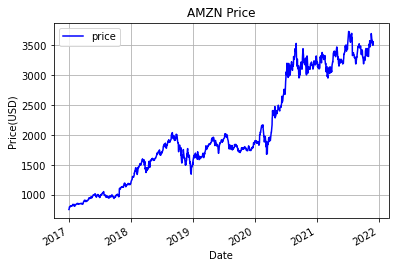

1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
2
Stock grossed: 365.33232686506597 %
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
3
count    1237.000000
mean     2062.805334
std       867.683801
min       753.669983
25%      1495.079956
50%      1822.489990
75%      3099.399902
max      3731.409912
Name: Close, dtype: float64
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
4


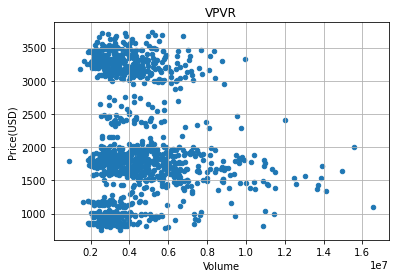

1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
5
Please let me know what stock information you want to know.goog
I am checking GOOG
                   High          Low         Open        Close   Volume  \
Date                                                                      
2021-11-30  2932.570068  2841.320068  2909.004883  2849.040039  1808526   

              Adj Close  
Date                     
2021-11-30  2849.040039  
Enter "Y" access portfolio tool. Or enter "N" stay.
n
6.Check My WatchingList
7.Integrate Graph of WatchingList
8.Enter Portfolio menu
Q.Quit
1
9.Simulate Best Portfolio (Find MVP)
10.Delete Symbol
Q.Quit

Please let me know what stock information you want to know.goog
I am checking GOOG
                   High          Low         Open        Close   Volume  \
Date                                                                      
2021-11-30  2932.570068  2841.32

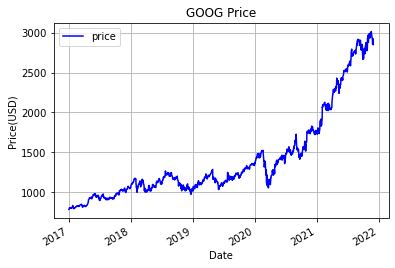

1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
2
Stock grossed: 262.40872948524225 %
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
3
count    1237.000000
mean     1417.659210
std       566.753329
min       786.140015
25%      1053.910034
50%      1192.849976
75%      1530.199951
max      3014.179932
Name: Close, dtype: float64
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
4


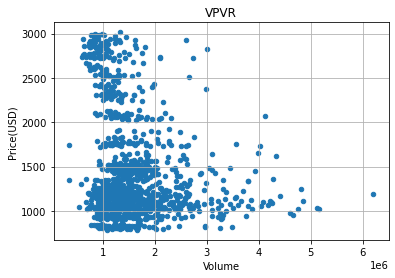

1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
5
Please let me know what stock information you want to know.nos.ls
I am checking NOS.LS
             High    Low  Open  Close     Volume  Adj Close
Date                                                       
2021-11-30  3.406  3.356  3.36  3.362  1335558.0      3.362
Enter "Y" access portfolio tool. Or enter "N" stay.
N
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
1


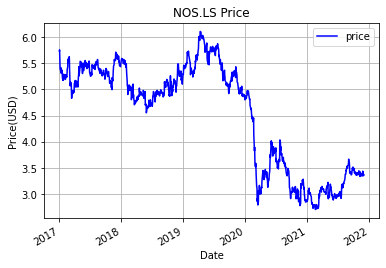

1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
2
Stock lost: -41.336590125884676 %
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
3
count    1257.000000
mean        4.516544
std         1.019192
min         2.708000
25%         3.398000
50%         4.944000
75%         5.350000
max         6.105000
Name: Close, dtype: float64
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
4


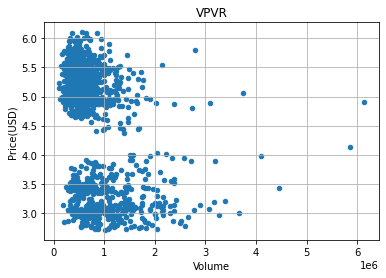

1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
5
Please let me know what stock information you want to know.
I am checking 
I cannot found information.
The symbol you entered is not list in Bot. Sorry.
Enter "Y" access portfolio tool. Or enter "N" stay.
Y
6.Check My WatchingList
7.Integrate Graph of WatchingList
8.Enter Portfolio menu
Q.Quit
6
Your watch list: ['GOOG', 'AMZN', 'NOS.LS']
6.Check My WatchingList
7.Integrate Graph of WatchingList
8.Enter Portfolio menu
Q.Quit
7


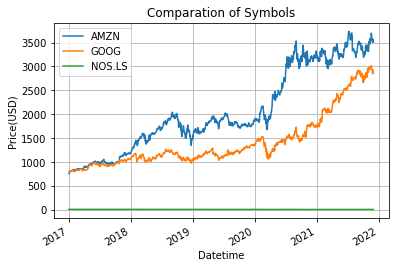

6.Check My WatchingList
7.Integrate Graph of WatchingList
8.Enter Portfolio menu
Q.Quit
8
Seems your are checking your portfolio, 
I already prepared some portfolio information.
Due to the network, I need your patiant to wait 30 seconds 
after eachtime your enter your command, thank!
9.Simulate Best Portfolio (Find MVP)
10.Delete Symbol
Q.Quit
9
I am simulating possible portfolio sets...
                            AMZN         GOOG  NOS.LS
2021-11-24 00:00:00  3580.409912  2934.350098   3.440
2021-11-25 00:00:00          NaN          NaN   3.398
2021-11-26 00:00:00  3504.560059  2856.120117   3.350
2021-11-29 00:00:00  3561.570068  2922.280029   3.382
2021-11-30 00:00:00  3507.070068  2849.040039   3.362


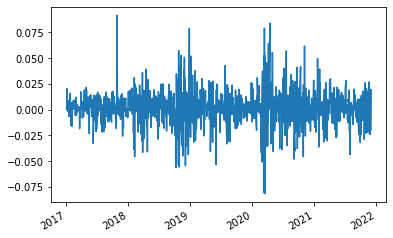

            AMZN      GOOG    NOS.LS
AMZN    0.088706  0.054266  0.008207
GOOG    0.054266  0.074214  0.012818
NOS.LS  0.008207  0.012818  0.060446
                            AMZN         GOOG  NOS.LS
2021-11-24 00:00:00  3580.409912  2934.350098   3.440
2021-11-25 00:00:00          NaN          NaN   3.398
2021-11-26 00:00:00  3504.560059  2856.120117   3.350
2021-11-29 00:00:00  3561.570068  2922.280029   3.382
2021-11-30 00:00:00  3507.070068  2849.040039   3.362


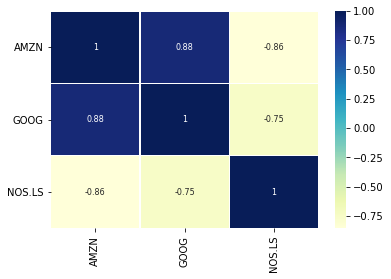

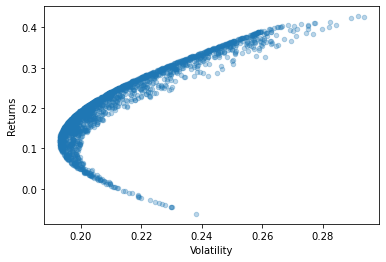

Now, I am pointing Minimum Variance Point...


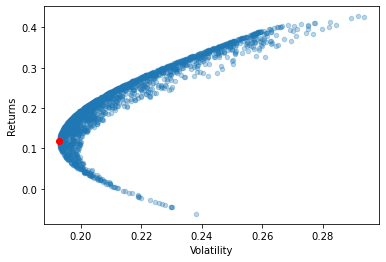

MVP volatility: 0.19 Expected Return: 0.12
-------------------------
-------------------------
Target Portfolio Weight:
-------------------------
      AMZN_weight  GOOG_weight  NOS.LS_weight   Returns  Volatility
1445     0.208829      0.26044       0.530731  0.117719    0.192858
There is the MVP return in time series.


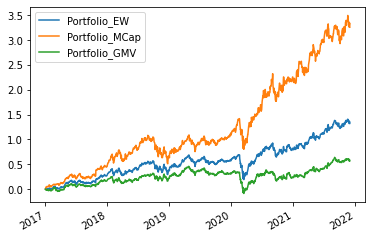

Sharp Ration is ready for you.


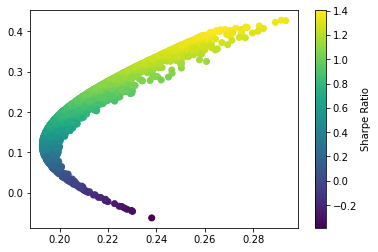

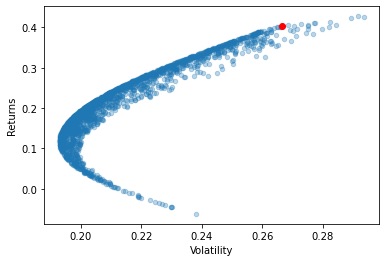

Finally, I'd like to share different weighted portfolio return


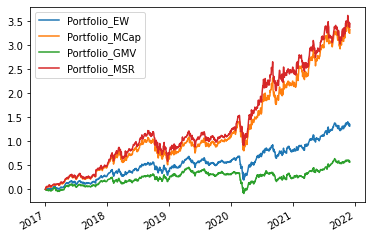

Now I will return to begining.
1.Price Trend
2.Price Change (Start from Jan. 2017)
3.Stock Statistic Conclusion
4.Volum Profile Visible Range
5.Add one more symbol
Q.Quit
Q


In [53]:
main()